In [1]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

from keras import Sequential
from keras.layers import Dense
import keras_tuner as kt

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers

In [3]:
### Entire data loaded at once

minmaxscaler = MinMaxScaler()

image_patch_size = 256

dataset_root_folder = r"path/datasets"
dataset_name = 'test'

image_dataset = []
mask_dataset = []
for image_type in ['images', 'mask']:
    if image_type == 'images':
        image_extension = 'png'
    elif image_type == 'mask':
        image_extension = 'png'

    for image_type in ['images', 'mask']:
        for image_id in range(0,6000):  # Adjust the range as needed
            image_path = f'{dataset_root_folder}/{dataset_name}/{image_type}/image_{image_id}.{image_extension}'
            if not os.path.exists(image_path):
                continue  # Skip to the next image_id if image not found
    
            image = cv2.imread(image_path, 1)
            if image is not None:
                if image_type == 'mask':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size
                #print(image.shape[0], image.shape[1], image.shape[2])
    
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))
                image = np.array(image)
    
                
                # Patchify the image
                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
    
                # Append patches to datasets
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == 'images':
                            individual_patched_image = patched_images[i, j, :, :]
                            individual_patched_image = minmaxscaler.fit_transform(
                                individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(
                                individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'mask':
                            individual_patched_mask = patched_images[i, j, :, :]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

# Convert datasets to numpy arrays
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

# Optionally save datasets to disk
#np.save(os.path.join(dataset_root_folder, dataset_name, 'image_dataset1.npy'), image_dataset)
#np.save(os.path.join(dataset_root_folder, dataset_name, 'mask_dataset1.npy'), mask_dataset)

In [ ]:
# # Memory-mapped loading
# mmapped_array1 = np.load('array1.npy', mmap_mode='r')
# mmapped_array2 = np.load('array2.npy', mmap_mode='r')

# # Combine arrays (in-memory operation for demonstration, might not be feasible for very large arrays)
# combined_array = np.concatenate((mmapped_array1, mmapped_array2), axis=0)
# print(f"Combined array shape: {combined_array.shape}")

In [4]:
print(mask_dataset.shape)

(3186, 256, 256, 3)


In [5]:
# Print lengths of datasets
print("Length of image dataset:", len(image_dataset))
print("Length of mask dataset:", len(mask_dataset))

Length of image dataset: 3186
Length of mask dataset: 3186


In [ ]:


# Assume image_dataset and mask_dataset are your datasets
image_number = random.randint(0, len(image_dataset) - 1)

plt.figure(figsize=(14, 8))

# Display the image with the image number
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.title(f'Image Number: {image_number}')

# Display the mask with the mask number (same as image number in this case)
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.title(f'Mask Number: {image_number}')

plt.show()


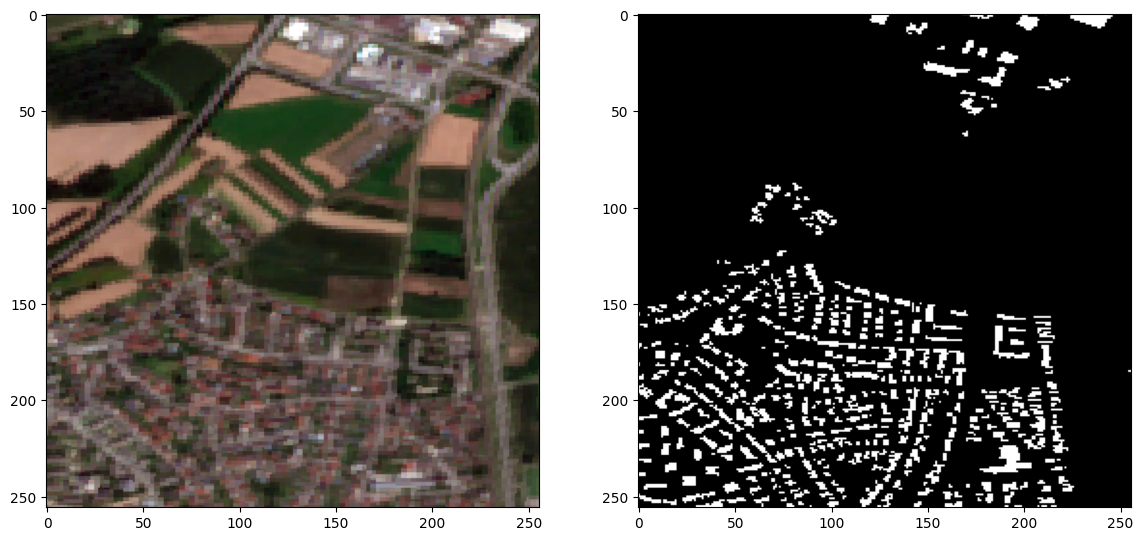

In [6]:
import random

image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(14,8 ))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [7]:
class_Building = '#FFFFFF'
class_Building = class_Building.lstrip('#')
class_Building = np.array(tuple(int(class_Building[i:i+2], 16) for i in (0,2,4)))
print(class_Building)

class_unlabeled = '#000000'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[255 255 255]
[0 0 0]


In [8]:

label = individual_patched_mask

def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  # label_segment[np.all(label == class_water, axis=-1)] = 3
  # label_segment[np.all(label == class_grassland, axis=-1)] = 2
  label_segment[np.all(label == class_Building, axis=-1)] = 1
  # label_segment[np.all(label == class_vegetation, axis=-1)] = 1
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 0
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

np.unique(labels)

print("Total unique labels based on masks: ",format(np.unique(labels)))


Total unique labels based on masks:  [0 1]


In [9]:
print(image_dataset.shape)

(3186, 256, 256, 3)


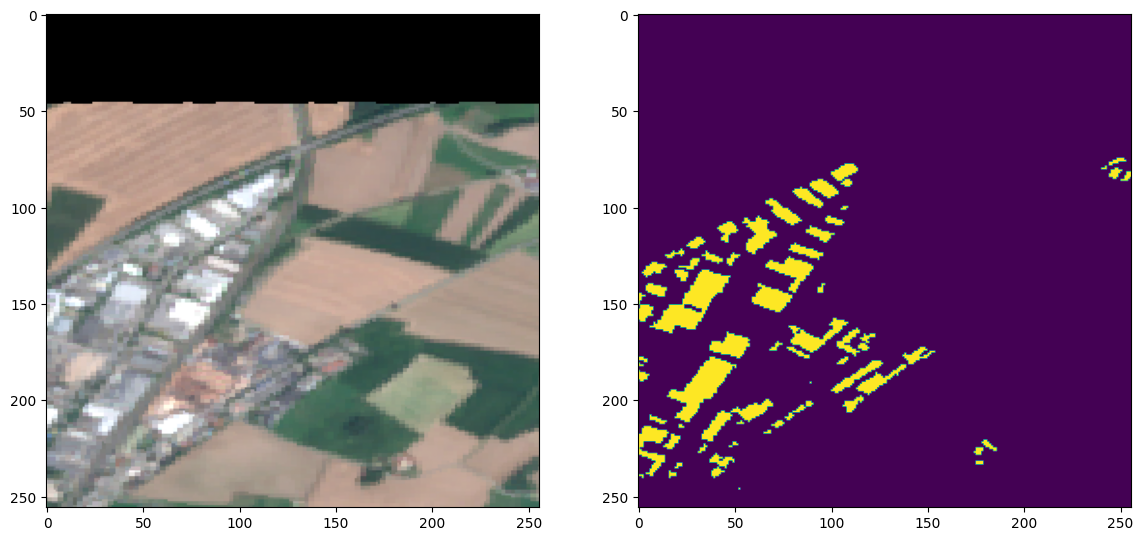

In [10]:
random_image_id = random.randint(0, len(image_dataset))
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

Randomly selected image ID: 3015


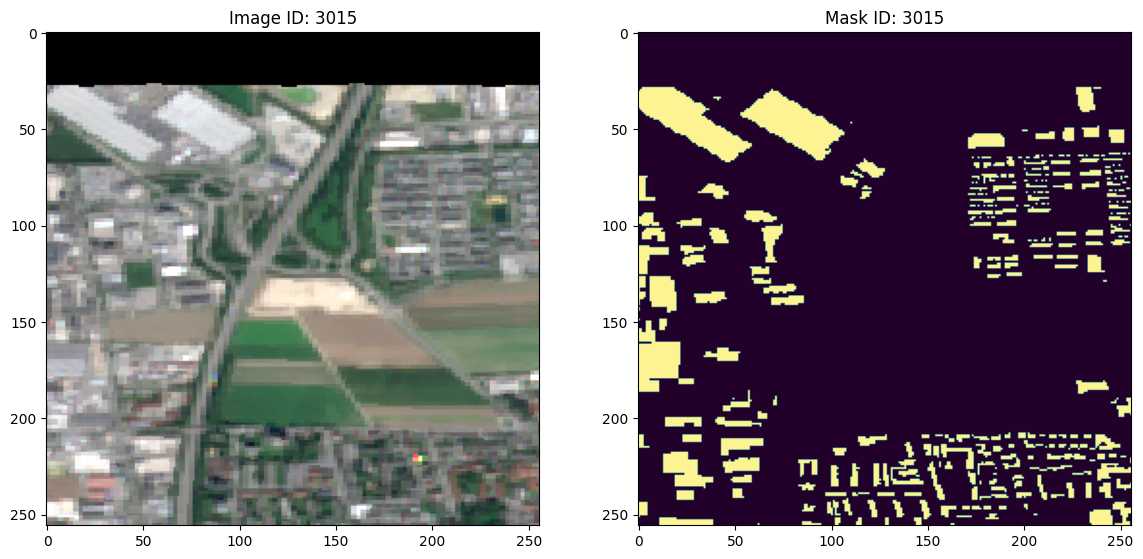

In [11]:

# Assuming `image_dataset`, `mask_dataset`, and `labels` are already defined and loaded

# Generate a random index within the range of the dataset
random_image_id = random.randint(0, len(image_dataset) - 1)

# Print the randomly selected image ID
print(f"Randomly selected image ID: {random_image_id}")

# Plot the image and corresponding mask
plt.figure(figsize=(14, 8))

plt.subplot(121)
plt.title(f"Image ID: {random_image_id}")
plt.imshow(image_dataset[random_image_id])

plt.subplot(122)
plt.title(f"Mask ID: {random_image_id}")
plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:, :, 0], alpha=0.5)

plt.show()


In [12]:
n_classes = len(np.unique(labels))
n_classes

from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)


print(len(np.unique(labels)))
print(labels_cat.shape)

2
(3186, 256, 256, 2)


In [13]:
### Direct split works with small data or else use below data-generators code

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.1, random_state = 42) ## can change test_size and random_state on usecases

print(X_train.shape)  ## Imagery
print(X_test.shape)
print(y_train.shape)   ## labels
print(y_test.shape)

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

(2867, 256, 256, 3)
(319, 256, 256, 3)
(2867, 256, 256, 2)
(319, 256, 256, 2)
256
256
3
2


In [ ]:

### USING DATA GENERATORS to use as chunks of data 

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Generate indices for training and testing sets
indices = np.arange(len(image_dataset))
train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42)

# Get sample shapes from the first training and testing indices
sample_train_image = image_dataset[train_indices[0]]  # X_train sample
sample_train_label = labels_cat[train_indices[0]]     # y_train sample
sample_test_image = image_dataset[test_indices[0]]    # X_test sample
sample_test_label = labels_cat[test_indices[0]]       # y_test sample

# Print shapes
print(f"X_train shape: {(len(train_indices), *sample_train_image.shape)}")  ## Imagery
print(f"X_test shape: {(len(test_indices), *sample_test_image.shape)}")
print(f"y_train shape: {(len(train_indices), *sample_train_label.shape)}")   ## labels
print(f"y_test shape: {(len(test_indices), *sample_test_label.shape)}")

# Get image and label dimensions
image_height = sample_train_image.shape[0]
image_width = sample_train_image.shape[1]
image_channels = sample_train_image.shape[2]
total_classes = sample_train_label.shape[2]  # Assuming y_train has shape (n_samples, height, width, num_classes)

print(f"Image height: {image_height}")
print(f"Image width: {image_width}")
print(f"Image channels: {image_channels}")
print(f"Total classes: {total_classes}")

# Custom data generator class
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, indices, batch_size=32, shuffle=True):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.images[k] for k in batch_indices]
        batch_labels = [self.labels[k] for k in batch_indices]
        
        X = np.array(batch_images)
        y = np.array(batch_labels)
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create generators for training and testing
batch_size = 32
train_generator = DataGenerator(image_dataset, labels_cat, train_indices, batch_size=batch_size)  # X_train, y_train
test_generator = DataGenerator(image_dataset, labels_cat, test_indices, batch_size=batch_size, shuffle=False)  # X_test, y_test

# Example model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, image_channels)),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(total_classes, activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model using the generators
# model.fit(train_generator, validation_data=test_generator, epochs=10)


In [ ]:
### eith augmentation

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming image_dataset and labels_cat are already defined
# Example:
# image_dataset = np.random.rand(100, 256, 256, 3)  # Replace with actual image data
# labels_cat = np.random.randint(0, 2, (100, 256, 256, 1))  # Replace with actual label data

# Generate indices for training and testing sets
indices = np.arange(len(image_dataset))
train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42)

# Get sample shapes from the first training and testing indices
sample_train_image = image_dataset[train_indices[0]]  # X_train sample
sample_train_label = labels_cat[train_indices[0]]     # y_train sample
sample_test_image = image_dataset[test_indices[0]]    # X_test sample
sample_test_label = labels_cat[test_indices[0]]       # y_test sample

# Print shapes
print(f"X_train shape: {(len(train_indices), *sample_train_image.shape)}")  ## Imagery
print(f"X_test shape: {(len(test_indices), *sample_test_image.shape)}")
print(f"y_train shape: {(len(train_indices), *sample_train_label.shape)}")   ## labels
print(f"y_test shape: {(len(test_indices), *sample_test_label.shape)}")

# Get image and label dimensions
image_height = sample_train_image.shape[0]
image_width = sample_train_image.shape[1]
image_channels = sample_train_image.shape[2]
total_classes = sample_train_label.shape[2]  # Assuming y_train has shape (n_samples, height, width, num_classes)

print(f"Image height: {image_height}")
print(f"Image width: {image_width}")
print(f"Image channels: {image_channels}")
print(f"Total classes: {total_classes}")

# Custom data generator class with augmentation
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, indices, batch_size=32, shuffle=True, augment=False):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        
        # Initialize ImageDataGenerator for augmentation
        self.image_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
        self.label_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.images[k] for k in batch_indices]
        batch_labels = [self.labels[k] for k in batch_indices]
        
        X = np.array(batch_images)
        y = np.array(batch_labels)

        # Apply augmentation if enabled
        if self.augment:
            X = self.image_datagen.flow(X, batch_size=self.batch_size, shuffle=False).next()
            y = self.label_datagen.flow(y, batch_size=self.batch_size, shuffle=False).next()
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create generators for training and testing
batch_size = 64
train_generator = DataGenerator(image_dataset, labels_cat, train_indices, batch_size=batch_size, augment=True)  # X_train, y_train with augmentation
test_generator = DataGenerator(image_dataset, labels_cat, test_indices, batch_size=batch_size, shuffle=False)  # X_test, y_test without augmentation


In [ ]:
# Initialize a counter
total_samples = 0

# Iterate through the test generator and count samples in each batch
for i in range(len(test_generator)):
    X_batch, y_batch = test_generator[i]
    total_samples += len(X_batch)

print(f"Total number of samples in test_generator: {total_samples}")


In [75]:
import tensorflow
from PIL import Image
import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
weights = [ 0.5, 0.5 ]  ### this is for weights = 1 / [Number of classes]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
### Deeper networks

def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#Build the model
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
  s = inputs
  #Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.2)(c1)  # Original 0.1
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.2)(c2)  # Original 0.1
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
  p5 = MaxPooling2D(pool_size=(2, 2))(c5)



  c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  #Expansive path
  u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c5])
  c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c4])
  c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c3])
  c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
  u10 = concatenate([u10, c2])
  c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
  c10 = Dropout(0.2)(c10)  # Original 0.1
  c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

  u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
  u11 = concatenate([u11, c1], axis=3)
  c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
  c11 = Dropout(0.2)(c11)  # Original 0.1
  c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

  outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c11)

  model = Model(inputs=[inputs], outputs=[outputs])

  #NOTE: Compile the model in the main program to make it easy to test with various loss functions
  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  #model.summary()

  return model

In [15]:
### Normal networks

def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH= 256, IMG_CHANNELS=3):
#Build the model
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
  s = inputs
  #Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.2)(c1)  # Original 0.1
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.2)(c2)  # Original 0.1
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)

  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.2)(c8)  # Original 0.1
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.2)(c9)  # Original 0.1
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

  outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  #NOTE: Compile the model in the main program to make it easy to test with various loss functions
  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  #model.summary()

  return model

In [16]:
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=image_height, IMG_WIDTH=image_width, IMG_CHANNELS=image_channels)

model = get_model()

In [17]:
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

model.summary()

model.input.shape

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

TensorShape([None, 256, 256, 3])

In [18]:
#### Training for direct X-train and  y_train

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(
    r"Germany_POC_2_150epoch_model_3000images_256size_checkpoint_{epoch:02d}_full_model.h5",
    monitor='val_loss',
    save_best_only= True,  # Set to False to save at each epoch
    save_weights_only=False,  # Set to False to save the entire model
    mode="auto",
    save_freq="epoch"
)

# Fit the model with callbacks
model_final = model.fit(
    X_train, y_train,
    batch_size=32,
    verbose=1,
    epochs=150,
    validation_data=(X_test, y_test),
    shuffle=False,
    callbacks=[checkpoint]
)


Epoch 1/150
90/90 [==============================] - 530s 6s/step - loss: 0.3314 - accuracy: 0.9096 - jacard_coef: 0.6822 - val_loss: 0.2952 - val_accuracy: 0.9081 - val_jacard_coef: 0.6651
Epoch 2/150
90/90 [==============================] - 518s 6s/step - loss: 0.2676 - accuracy: 0.9121 - jacard_coef: 0.7339 - val_loss: 0.2735 - val_accuracy: 0.9081 - val_jacard_coef: 0.7375
Epoch 3/150
90/90 [==============================] - 520s 6s/step - loss: 0.2546 - accuracy: 0.9121 - jacard_coef: 0.7433 - val_loss: 0.2761 - val_accuracy: 0.9081 - val_jacard_coef: 0.7630
Epoch 4/150
90/90 [==============================] - 517s 6s/step - loss: 0.2441 - accuracy: 0.9121 - jacard_coef: 0.7491 - val_loss: 0.3706 - val_accuracy: 0.9081 - val_jacard_coef: 0.7964
Epoch 5/150
90/90 [==============================] - 519s 6s/step - loss: 0.2368 - accuracy: 0.9121 - jacard_coef: 0.7531 - val_loss: 0.4445 - val_accuracy: 0.9081 - val_jacard_coef: 0.8078
Epoch 6/150
90/90 [==============================]

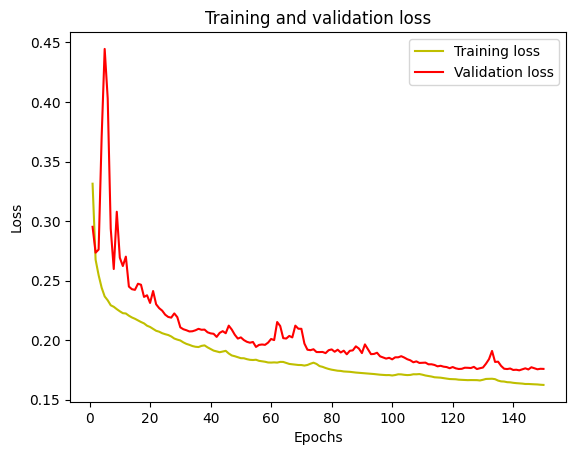

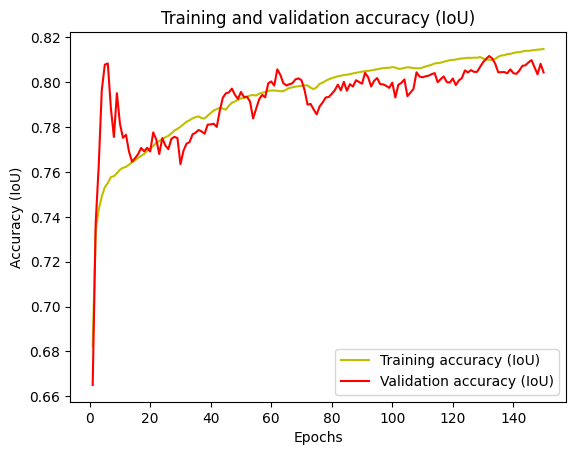

In [70]:
import matplotlib.pyplot as plt

# Assuming 'history' contains the training history
history= model_final
# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy (or IoU if you tracked IoU)
acc = history.history['jacard_coef']  # Assuming 'jacard_coef' is recorded during training
val_acc = history.history['val_jacard_coef']  # Assuming 'val_jacard_coef' is recorded during training

plt.plot(epochs, acc, 'y', label='Training accuracy (IoU)')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy (IoU)')
plt.title('Training and validation accuracy (IoU)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (IoU)')
plt.legend()
plt.show()


In [ ]:
## Resuming training from where it got stopped

import tensorflow as tf
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K



last_checkpoint = r"Germany_47_model_checkpoint_8000img.h5"
model = load_model(last_checkpoint, custom_objects={
    'jacard_coef': jacard_coef,
    'total_loss': total_loss,
    'DiceLoss': sm.losses.DiceLoss,
    'CategoricalFocalLoss': sm.losses.CategoricalFocalLoss})

### With data generators

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(r"Germany_{epoch:02d}_model_checkpoint_8000img.h5", 
                             monitor='val_loss', save_best_only=True,
                            save_weights_only=False,
                            mode="auto",
                            save_freq="epoch",
                            initial_value_threshold=None)


initial_epoch = 49
total_epochs = 55

# Fit the model with callbacks using the generators
final = model.fit(train_generator,
                  batch_size=32,

                  epochs=total_epochs,
                  
                  initial_epoch=initial_epoch,
                  verbose=1,
                  validation_data=test_generator,
                  shuffle=True,
                  callbacks=[checkpoint])





In [ ]:
### With data generators from starting the training

from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(r"Germany_POC_{epoch:02d}_model_checkpoint_8000img.h5", 
                             monitor='val_loss', save_best_only=True,
                            save_weights_only=False,
                            mode="auto",
                            save_freq="epoch",
                            initial_value_threshold=None)


# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with callbacks using the generators
final = model.fit(train_generator,
                  batch_size=32,

                  epochs=150,
                  verbose=1,
                  validation_data = test_generator,
                  shuffle=False,
                  callbacks=[checkpoint])


In [ ]:
## Predictions from test generators

import numpy as np
import matplotlib.pyplot as plt
import random

# Step 1: Pick a random image from the test generator
test_img_number = random.randint(0, len(test_generator) - 1)

# Extract a batch of images and labels from the generator
test_batch = test_generator[test_img_number]
test_img = test_batch[0]  # This is the batch of images (X_test)
test_label = test_batch[1]  # This is the batch of labels (y_test)

# Step 2: Select one image and corresponding label from the batch
test_img_single = test_img[0]  # The first image in the batch
ground_truth_single = test_label[0]  # The corresponding label

# Step 3: Predict the output for the selected test image
test_img_input = np.expand_dims(test_img_single, 0)  # Expand dims to fit model input shape
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0, :, :]  # Get the predicted class map

# Step 4: Visualize the testing image, ground truth, and prediction
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_single)

plt.subplot(232)
plt.title('Testing Label (Ground Truth)')
plt.imshow(np.argmax(ground_truth_single, axis=2))  # Assuming one-hot encoded labels

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(predicted_img)

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to visualize random test samples with predictions
def visualize_random_predictions_from_test(test_generator, model, num_samples=3):
    # Ensure we don't exceed the available samples in the test set
    total_batches = len(test_generator)
    
    # Loop through a number of random samples
    for i in range(num_samples):
        # Randomly choose a batch from the test generator
        test_img_number = random.randint(0, total_batches - 1)
        
        # Extract the batch of images and labels from the generator
        test_batch = test_generator[test_img_number]
        test_img_batch = test_batch[0]  # X_test (batch of test images)
        test_label_batch = test_batch[1]  # y_test (batch of test labels)
        
        # Randomly choose one image from the batch
        batch_size = len(test_img_batch)
        random_index = random.randint(0, batch_size - 1)
        
        # Select the test image and its corresponding ground truth label
        test_img_single = test_img_batch[random_index]  # The chosen image
        ground_truth_single = test_label_batch[random_index]  # The corresponding ground truth
        
        # Predict the output for the selected test image
        test_img_input = np.expand_dims(test_img_single, 0)  # Expand dims to fit model input shape
        prediction = model.predict(test_img_input)
        predicted_img = np.argmax(prediction, axis=3)[0, :, :]  # Get the predicted class map
        
        # Plot the results: test image, ground truth, and prediction
        plt.figure(figsize=(12, 8))
        
        plt.subplot(131)
        plt.title('Testing Image')
        plt.imshow(test_img_single)
        
        plt.subplot(132)
        
        plt.title('Testing Label (Ground Truth)')
        plt.imshow(np.argmax(ground_truth_single, axis=2))  # Assuming one-hot encoded labels
        
        plt.subplot(133)
        plt.title('Prediction on Test Image')
        plt.imshow(predicted_img)
        
        plt.show()

# Call the function to visualize random predictions
visualize_random_predictions_from_test(test_generator, model, num_samples=3)


In [19]:

### Checking the predictions for X_test
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

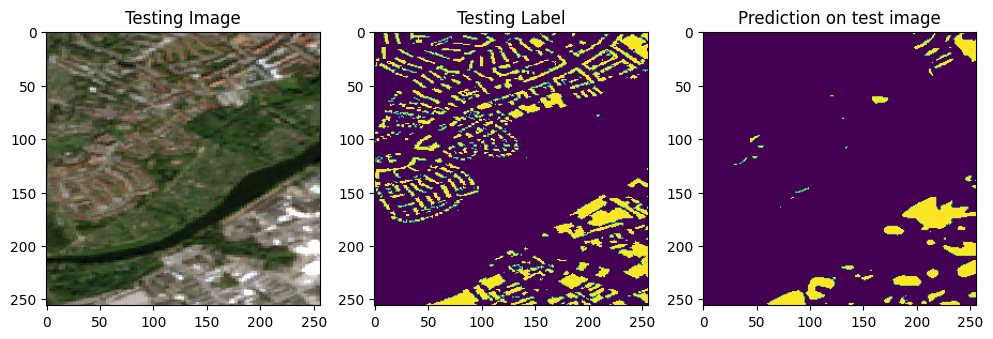

In [78]:
### Checking the predictions 
#IOU


import random
test_img_number = random.randint(0, len(X_test)- 1)
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
#print(prediction)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
from patchify import patchify
from matplotlib import pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Parameters
image_patch_size = 256
image_path = r"image_1896.png"
model_path = r"\sentinel_2_berlin_POC_150epoch_model_checkpoint_130000img.h5"
output_image_path = r"predicted_output_image_1896.png"

# Load the image
image = cv2.imread(image_path, 1)

# Ensure the image dimensions are divisible by the patch size
size_x = (image.shape[1] // image_patch_size) * image_patch_size
size_y = (image.shape[0] // image_patch_size) * image_patch_size

# Crop the image to ensure dimensions are divisible by patch size
image = Image.fromarray(image)
image = image.crop((0, 0, size_x, size_y))
image = np.array(image)

# Patchify the image into 256x256 patches
patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)

# Load the model
model = load_model(model_path, compile=False) ## if want  custom_objects={'jacard_coef': jacard_coef}

# Initialize MinMaxScaler for scaling the patches
minmaxscaler = MinMaxScaler()

# Initialize a placeholder for storing predicted patches (single channel)
predicted_patches = np.zeros((patched_images.shape[0], patched_images.shape[1], image_patch_size, image_patch_size))

# Loop through each patch and make predictions
for i in range(patched_images.shape[0]):
    for j in range(patched_images.shape[1]):
        # Extract the individual patch
        individual_patched_image = patched_images[i, j, 0]
        
        # Apply MinMaxScaler to scale the patch
        individual_patched_image = minmaxscaler.fit_transform(
            individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
        
        # Expand dimensions to match model input (batch size, height, width, channels)
        patch_input = np.expand_dims(individual_patched_image, axis=0)
        
        # Predict the patch using the model
        predicted_patch = model.predict(patch_input)
        
        # Convert predicted patch to class labels (argmax over the channels)
        predicted_patch = np.argmax(predicted_patch, axis=3)[0]  # The result is now (256, 256)
        
        # Store the predicted patch (2D)
        predicted_patches[i, j] = predicted_patch

        # Display the original and predicted patch side by side
        plt.figure(figsize=(8, 4))
        plt.subplot(121)
        plt.title(f'Original Patch [{i},{j}]')
        plt.imshow(individual_patched_image)
        plt.subplot(122)
        plt.title(f'Predicted Patch [{i},{j}]')
        plt.imshow(predicted_patch, cmap='gray')
        plt.show()

# Unpatchify if you want to reconstruct the full image (if you have multiple patches)
# full_image = unpatchify(predicted_patches, image.shape)


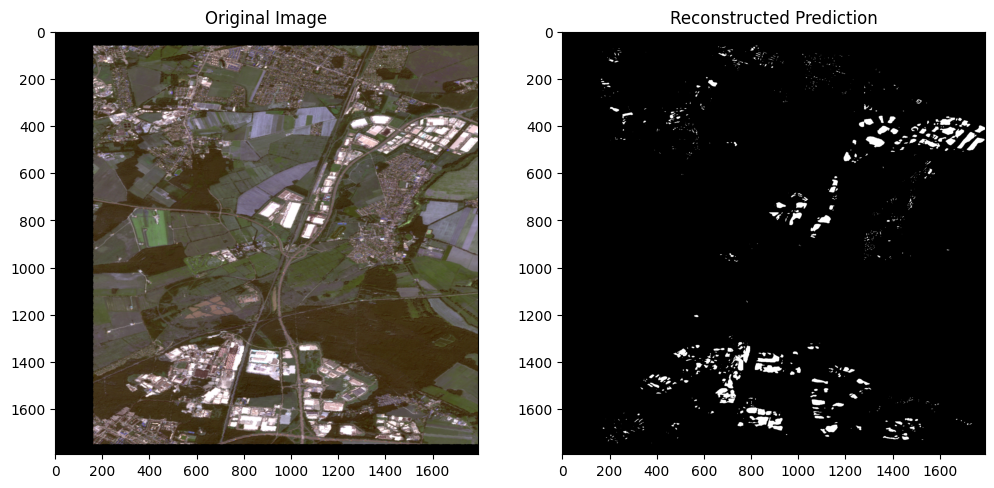

In [92]:
# Unpatchify to reconstruct the image from the predicted patches
reconstructed_image = unpatchify(predicted_patches, (size_y, size_x))

# Apply a color map to the reconstructed image for better visibility
colored_reconstructed_image = cv2.applyColorMap(reconstructed_image.astype(np.uint8), cv2.COLORMAP_JET)

# Save the output image in high resolution with color
output_image = Image.fromarray(colored_reconstructed_image)
#output_image.save(r'F:\Work\SantoshSV4\Germany\Training_final_files\sticted_predicted_image_5m_184.png')

# Plot the original image and the colorized reconstructed prediction
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.title('Reconstructed Prediction')
plt.imshow(reconstructed_image, cmap='gray')
plt.show()


In [ ]:
#### Predictions for TIFF files
import  rasterio
import numpy as np
#from tifffile import imread, imwrite
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from rasterio.transform import from_origin

# Parameters
image_patch_size = 256
image_path = r"grid_1084_masked_resampled_1m.tif"
model_path = r"sentinel_2_berlin_POC_150epoch_model_checkpoint_130000img.h5"
output_image_path = r"predicted_output_image_1084_1m.tif"


# Open the GeoTIFF file using rasterio
with rasterio.open(image_path) as src:
    image = src.read()  # Read all bands
    image = np.moveaxis(image, 0, -1)  # Reorder axes to (height, width, channels)
    
    # Keep the georeferencing information to save in the output TIFF
    transform = src.transform
    crs = src.crs

# Check if the image has more than 3 channels (e.g., RGBA or additional bands)
if image.shape[2] > 3:
    image = image[:, :, :3]  # Keep only the first 3 channels (RGB)

# Convert 16-bit unsigned integers to 8-bit integers (normalize to 0-255)
if image.dtype == np.uint16:  # Check if the image is 16-bit
    image = (image / 256).astype(np.uint8)  # Scale down to 8-bit (0-255)

# Resize image to be divisible by patch size
size_x = (image.shape[1] // image_patch_size) * image_patch_size
size_y = (image.shape[0] // image_patch_size) * image_patch_size

# Crop the image to match the patch size dimensions
image = image[:size_y, :size_x, ...]

print(f"Processing image with dimensions: {image.shape[0]}x{image.shape[1]}, Channels: {image.shape[2]}")

# Patchify the image into 256x256 patches
patched_images = patchify(image, (image_patch_size, image_patch_size, image.shape[2]), step=image_patch_size)

# Load the pre-trained model
model = load_model(model_path, compile=True, custom_objects={'jacard_coef': jacard_coef})

# Initialize MinMaxScaler for scaling patches
minmaxscaler = MinMaxScaler()

# Initialize placeholder for predicted patches
predicted_patches = np.zeros((patched_images.shape[0], patched_images.shape[1], image_patch_size, image_patch_size))

# Loop through each patch and make predictions
for i in range(patched_images.shape[0]):
    for j in range(patched_images.shape[1]):
        # Extract the individual patch
        individual_patched_image = patched_images[i, j, 0]

        # Apply MinMaxScaler to scale the patch
        individual_patched_image = minmaxscaler.fit_transform(
            individual_patched_image.reshape(-1, individual_patched_image.shape[-1])
        ).reshape(individual_patched_image.shape)

        # Expand dimensions to match model input (batch size, height, width, channels)
        patch_input = np.expand_dims(individual_patched_image, axis=0)

        # Predict the patch using the model
        predicted_patch = model.predict(patch_input)

        # Convert predicted patch to class labels (argmax over the channels)
        predicted_patch = np.argmax(predicted_patch, axis=3)[0]

        # Store the predicted patch (2D)
        predicted_patches[i, j] = predicted_patch

        # Display the original and predicted patch side by side (optional)
        plt.figure(figsize=(8, 4))
        plt.subplot(121)
        plt.title(f'Original Patch [{i},{j}]')
        plt.imshow(individual_patched_image)
        plt.subplot(122)
        plt.title(f'Predicted Patch [{i},{j}]')
        plt.imshow(predicted_patch, cmap='gray')
        plt.show()

# Unpatchify the predicted patches back into the full predicted image
predicted_image = unpatchify(predicted_patches, (size_y, size_x))

# Save the predicted image as a GeoTIFF
with rasterio.open(
    output_image_path, 'w', 
    driver='GTiff', 
    height=predicted_image.shape[0], 
    width=predicted_image.shape[1], 
    count=1,  # Since the output is single-channel (binary prediction)
    dtype=rasterio.uint8,  # Change the datatype based on your output (e.g., uint8)
    crs=crs, 
    transform=transform
) as dst:
    dst.write(predicted_image, 1)

print(f"Predicted output saved to {output_image_path}")       


In [ ]:
## After model trained immediately check the test data

from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
a= load_model(r"final_model_100_epoch.h5", compile= False)


In [ ]:
# #IOU
y_pred=model.predict(test_generator)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)



In [ ]:
#IOU for test generators and predictions for a given model 

##  Loading the model 

import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import keras.backend as K
import segmentation_models as sm
import random

# Define the loss and metric functions
weights = [0.5, 0.5]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

# Define custom objects dictionary
custom_objects = {
    'jacard_coef': jacard_coef,  
    'total_loss': total_loss
}

# Path to your msentinel_2_berlin_POC_150epoch_model_checkpoint_130000img.h5odel file
model_path = r"F:\Work\SantoshSV4\Germany\Training_final_files\epoch\Germany_POC_51_model_checkpoint_8000img.h5"

# Load the model with the custom objects
model = load_model(model_path, custom_objects=custom_objects, compile=True)

# Display the model summary
model.summary()

# Assume the DataGenerator class and other code from above is already defined

# Extract a single batch from the test generator
X_test, y_test = test_generator[random.randint(0, len(test_generator) - 1)]

# Convert ground truth to class labels
y_test_argmax = np.argmax(y_test, axis=-1)

# Choose a random image from the batch
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]

# Prepare the image for prediction
test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0]

# Plotting the results
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(predicted_img)

plt.show()

